### this notebook processes VizieR (and with some tweaking, non-VizieR) catalogs for input into oncdb

### setup -- run all cells in this section upon notebook startup

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

from scipy.stats import norm

from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astropy.coordinates import Angle, Latitude, Longitude
import astropy.units as u

In [2]:
# progress meter for big loops
# progress must go from 0 to 100 because reasons

def progress_meter(progress):
    sys.stdout.write("\rloading... %.1f%%" % progress)
    sys.stdout.flush()

In [3]:
# fxn to group sources

# onc_df -- the dataframe of pairwise distances
# dist_crit -- the cross-matching radius (observations within this radius will be grouped together as a source)

def group_sources(onc_df, dist_crit):
    # 'new source' numbering starts at highest ACS number + 1
    new_source = max(onc_df.loc[onc_df['catname'] == 'ACS', 'catID'].values) + 1

    exclude = set()

    for k in range(len(onc_df)):

        if k not in exclude:

            # find where dist < dist_crit
            m = onc_df.loc[onc_df[str(k)] < dist_crit]

            mindex = set(m[str(k)].index.tolist())

            mindex_updated = set(m[str(k)].index.tolist())
            
            # initially set False to ensure it goes through the loop at least once
            mindex_same = False

            # keep adding match values until no new values are added
            while mindex_same == False:
                for x in mindex:
                    y = onc_df.loc[onc_df[str(x)] < dist_crit]

                    yindex = set(y[str(x)].index.tolist())

                    mindex_updated.update(yindex)
                
                # drops out of loop if no new things are added
                mindex_same = (mindex == mindex_updated)

                mindex.update(mindex_updated)
            
            # if already grouped, don't need to do it again
            exclude.update(mindex)

            num_group = len(mindex)

            match = onc_df.loc[mindex,['catname','catID']]

            # check for multiple objects in same catalog (any duplicates will flag as True)
            if match.duplicated(subset='catname',keep=False).any() == True:

                onc_df.loc[mindex,'oncflag'] = 'd'
            
            # check for one-to-one matches between ACS sources and new_cat sources (when new_cat is not ACS)
            elif (cat_info[0] != 'ACS') and\
            ('ACS' in match['catname'].values) and (cat_info[0] in match['catname'].values):

                onc_df.loc[mindex,'oncflag'] = 'o'
            
            onc_df.loc[mindex,'oncflag'] += str(num_group)
            
            # use ACS number if it exists -- if multiple, use lowest
            if ('ACS' in match['catname'].values) == True:
                onc_df.loc[mindex,'oncID'] = min(match.loc[match['catname'] == 'ACS','catID'].values)

            # otherwise give it a new number
            else:
                onc_df.loc[mindex,'oncID'] = new_source
                new_source += 1

            progress_meter(k*100./len(onc_df))
    
    print '\n'
    
    # change id columns to ints (defaults to floats...)
    onc_df.loc[:,'catID'] = onc_df.loc[:,'catID'].astype(int)
    onc_df.loc[:,'oncID'] = onc_df.loc[:,'oncID'].astype(int)
    
    return onc_df

In [4]:
# fxn to generate a matrix of pairwise distances between every pair of objects

# FUTURE -- this fxn can probably be rewritten with multi-processing for a significant speed increase

# c_new -- astropy coords (deg) for new catalog
# c_onc -- astropy coords (deg) for existing database
# new_cat -- entire new catalog
# onc_ex -- entire existing database

def get_pw_dists(c_new, c_onc, new_cat, onc_ex):

    cross_dist = pd.DataFrame()
    self_dist = pd.DataFrame()

    for k in range(len(c_new)):

        # sep between new_cat and existing oncdb objects
        sep_cross = c_onc.separation(c_new[k]).arcsecond

        # internal sep between new_cat objects
        sep_self = c_new.separation(c_new[k]).arcsecond

        cross_dist.loc[:,k] = sep_cross
        self_dist.loc[:,k] = sep_self

        progress_meter(k*100./len(c_new))

    print '\n'

    # join existing pw dist df (onc_ex) with cross_dist & self_dist dfs

    '''
     -------------------------------------
    |        onc_ex          | cross_dist |
    |-------------------------------------|
    | new_cat | cross_dist.T | self_dist  |
     -------------------------------------
    '''
    
    # offsetting indices to make it join properly
    nc_join = new_cat.rename(index = lambda x: (int(x) + len(onc_ex)), inplace=False)

    cross_dist.rename(columns = lambda x: (int(x) + len(onc_ex)), inplace=True)
    self_dist.rename(columns = lambda x: (int(x) + len(onc_ex)), inplace=True)
    self_dist.rename(index = lambda x: (int(x) + len(onc_ex)), inplace=True)
    
    # join
    pw1 = onc_ex.join(cross_dist)
    pw2 = nc_join.join(cross_dist.transpose().join(self_dist))

    pw1.columns = pw1.columns.astype(str)
    pw2.columns = pw2.columns.astype(str)

    onc_pw = pd.concat([pw1,pw2], ignore_index=True)

    return onc_pw

In [5]:
# fxn to determine systematic, linear offsets between catalogs

# FUTURE -- do this with TweakReg, which also accounts for rotation/scaling
# (see thread at https://github.com/spacetelescope/drizzlepac/issues/77)

# onc_gr -- full pairwise distance matrix after grouping
# catname -- name of new catalog (will always be compared against ACS)
# ra_col -- name of column containing RA
# dec_col -- name of column containing Dec

def find_offsets(onc_gr, catname, ra_col, dec_col):
    
    # restrict to one-to-one matches, sort by oncID so that matches are paired
    o2o_new = onc_gr.loc[(onc_gr['oncflag'].str.contains('o')) & (onc_gr['catname'] == catname) ,:].sort_values('oncID')
    o2o_acs = onc_gr.loc[(onc_gr['oncID'].isin(o2o_new['oncID']) & (onc_gr['catname'] == 'ACS')), :].sort_values('oncID')
    
    # get coords
    c_o2o_new = SkyCoord(o2o_new.loc[o2o_new['catname'] == catname, ra_col],\
                         o2o_new.loc[o2o_new['catname'] == catname, dec_col], unit='degree')
    c_o2o_acs = SkyCoord(o2o_acs.loc[o2o_acs['catname'] == 'ACS', ra_col],\
                         o2o_acs.loc[o2o_acs['catname'] == 'ACS', dec_col], unit='degree')

    print len(c_o2o_acs), 'one-to-one matches found'

    delta_ra = []
    delta_dec = []

    for i in range(len(c_o2o_acs)):
        # offsets FROM ACS TO new catalog
        ri, di = c_o2o_acs[i].spherical_offsets_to(c_o2o_new[i])

        delta_ra.append(ri.arcsecond)
        delta_dec.append(di.arcsecond)

        progress_meter(i*100./len(c_o2o_acs))

    delta_ra = np.array(delta_ra)
    delta_dec = np.array(delta_dec)

    print '\n'
    
    # fit a gaussian
    mu_ra, std_ra = norm.fit(delta_ra)
    mu_dec, std_dec = norm.fit(delta_dec)

    print 'Delta RA (arcsec):', mu_ra
    print 'Delta DEC (arcsec):', mu_dec
    
    return (delta_ra, delta_dec, mu_ra, mu_dec, std_ra, std_dec)

### file root path -- expects inputs to be in this directory, and writes outputs to this directory

In [6]:
root = '/Users/alin/Documents/'

### check contents of oncdb

In [7]:
# shows which catalogs are in an oncdb input file, and how many objects they have

# file to check (either pw_dist or db_input file)
onc_curr_name = 't3_db_input.txt'

# ====

onc_curr = pd.read_csv(root + onc_curr_name, sep='\t', engine='python')

print onc_curr['catname'].value_counts()

WFC3      4510
ACS       3399
NICMOS    2116
WFPC2     1488
Name: catname, dtype: int64


### add new cat to existing oncdb -- pairwise dist matrix must exist already, initial setup with ACS is special (see separate section below)

In [ ]:
# export catalogs directly from Viz as 'tab-separated values' (tsv)
# will need to comment out the two lines between the header and the data (comment = #)

# REQUIRED
# unique catalog ID -- a number uniquely identifying each object (not necessarily each observation) in the catalog
# (if catalog doesn't have unique IDs, can use Viz internal record number (recno) by including it in export)

# RA (deg) & DEC (deg), J2000 -- should be automatically generated by Viz, include these columns in export

# any data (photometry, etc) or info beyond these parameters is technically not required

In [ ]:
# OPTIONAL -- likely only needed if catalog is not downloaded from Viz
# otherwise, skip to next cell

# example of taking a whitespace-separated ascii table and turning it into the proper format

# in this case, only the first three columns (index, RAdeg, and DEdeg) are used
# np.genfromtxt and pd.read_csv both got confused by the flags because columns are separated by varying whitespace
# this is fine though -- catalog ID, RA (deg), and DEC (deg) are the bare minimum data required

temp = np.genfromtxt(root + 'AASTEX_Slimtable_FINAL.txt', skip_header=26, usecols=(0,1,2))

df = pd.DataFrame(temp, columns=['ONCwfc3', '_RAJ2000', '_DEJ2000'])

df.to_csv(root + 'wfc3_minimal.tsv', sep='\t', index=False)

In [8]:
# export directly from Viz as 'tab-separated values' (tsv)
# need to comment out the two lines between the header and the data (comment = #)

# there is a way to use astroquery to access Viz tables directly
# however it's a bit slow and requires internet connection

# Robberto 2013, HST Treasury Program on the ONC
# WFPC2 is J/ApJS/207/10/table6
# NICMOS is J/ApJS/207/10/table7

# filename of existing pairwise dist matrix (tsv)
onc_ex_name = 't3_wfpc2.tsv'

# filename for updated pairwise dist matrix (tsv)
onc_up_name = 't3_wfc3.tsv'

# catalog info as a tuple -- ('catname', 'filename', 'catID column name')
cat_info = ('WFC3', 'wfc3_minimal.tsv', 'ONCwfc3')

'''
('ACS', 'viz_acs.tsv', 'ONCacs')
('WFPC2', 'viz_wfpc2.tsv', 'ONCpc2')
('NICMOS', 'viz_nicmos.tsv', 'ONCnic3')
('WFC3', 'wfc3_minimal.tsv', 'ONCwfc3')
'''

# radius for xmatch (arcsec), pre- and post-shift
# pre should be relatively generous in case of offset
dist_crit_pre = 1.
dist_crit_post = 0.25

# ====

# if not Viz standard format, may have to set options to get it to read in properly

# for normal Viz catalogs
new_cat = pd.read_csv(root + cat_info[1], sep='\t', comment='#', engine='python')

# ====

# show table to check that it looks correct
new_cat

,ONCwfc3,_RAJ2000,_DEJ2000
0,0.0,83.626381,-5.457797
1,1.0,83.608998,-5.441777
2,2.0,83.616348,-5.442953
3,3.0,83.632944,-5.443575
4,4.0,83.617540,-5.444363
5,5.0,83.600199,-5.440295
6,6.0,83.624958,-5.421466
7,7.0,83.622401,-5.431073
8,8.0,83.642761,-5.443064
9,9.0,83.619187,-5.461625


In [9]:
# compress multiple observations of a single object in the catalog
new_cat = new_cat[[cat_info[2],'_RAJ2000','_DEJ2000']].groupby(cat_info[2]).agg(lambda x: np.mean(x))

# insert columns for later
new_cat.insert(0,'dec_corr', np.nan)
new_cat.insert(0,'ra_corr', np.nan)

new_cat.insert(0,'catID', new_cat.index)
new_cat.insert(0,'catname', cat_info[0])
new_cat.insert(0,'oncflag', '')
new_cat.insert(0,'oncID', np.nan)

new_cat = new_cat.reset_index(drop=True)

print 'new catalog', cat_info[0], 'has', len(new_cat), 'objects'

onc_ex = pd.read_csv(root + onc_ex_name, sep='\t', engine='python')

print 'existing oncdb has', len(onc_ex), 'objects'

new catalog WFC3 has 4510 objects
existing oncdb has 7003 objects


loading... 100.0%

loading... 100.0%

6130 unique sources
2697 one-to-one matches found
loading... 100.0%

Delta RA (arcsec): 0.0318348395914
Delta DEC (arcsec): -0.0101470770419


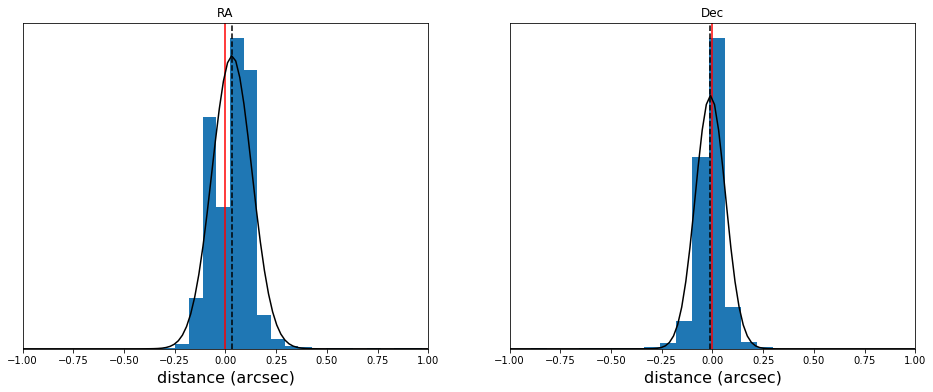

In [10]:
c_new = SkyCoord(new_cat['_RAJ2000'], new_cat['_DEJ2000'], unit='degree')
c_onc = SkyCoord(onc_ex['_RAJ2000'], onc_ex['_DEJ2000'], unit='degree')

# clear the flag column
onc_ex.loc[:,'oncflag'] = ''
new_cat.loc[:,'oncflag'] = ''

onc_iv = get_pw_dists(c_new, c_onc, new_cat, onc_ex)

onc_iv = group_sources(onc_iv, dist_crit_pre)

print len(onc_iv['oncID'].value_counts()), 'unique sources'

delta_ra, delta_dec, mu_ra, mu_dec, std_ra, std_dec = find_offsets(onc_iv, cat_info[0], '_RAJ2000', '_DEJ2000')

# plot histograms for ra/dec
f, (ax_ra, ax_dec) = plt.subplots(1, 2, figsize=(16,6))

ax_ra.hist(delta_ra, bins=20, normed=True)
ax_ra.set_xlim(-1,1)
ax_ra.axvline(0, color='r')
ax_ra.axvline(mu_ra, color='k', linestyle='dashed')
ax_ra.set_title('RA', fontsize=16)
ax_ra.set_xlabel('distance (arcsec)', fontsize=16)
ax_ra.yaxis.set_visible(False)

r = np.linspace(-1, 1, 100)
ax_ra.plot(r, norm.pdf(r,mu_ra,std_ra), 'k')

ax_dec.hist(delta_dec, bins=20, normed=True)
ax_dec.set_xlim(-1,1)
ax_dec.axvline(0, color='r')
ax_dec.axvline(mu_dec, color='k', linestyle='dashed')
ax_dec.set_title('Dec', fontsize=16)
ax_dec.set_xlabel('distance (arcsec)', fontsize=16)
ax_dec.yaxis.set_visible(False)

d = np.linspace(-1, 1, 100)
ax_dec.plot(d, norm.pdf(d,mu_dec,std_dec), 'k')

loading... 100.0%

loading... 100.0%

6905 unique sources
2793 one-to-one matches found
loading... 100.0%

Delta RA (arcsec): 0.0075485994011
Delta DEC (arcsec): 0.00225914835152


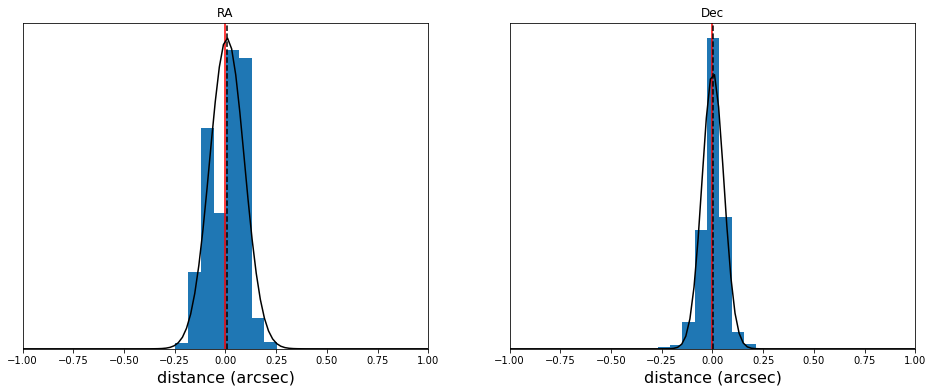

In [11]:
# tweak new_cat coords by linear offset

ra_v2 = new_cat.loc[:,'_RAJ2000'] - np.cos(new_cat.loc[:,'_DEJ2000']) * (mu_ra/3600.)
dec_v2 = new_cat.loc[:,'_DEJ2000'] - (mu_dec/3600.)

new_cat.loc[:,'ra_corr'] = ra_v2
new_cat.loc[:,'dec_corr'] = dec_v2

# clear the flag column
onc_ex.loc[:,'oncflag'] = ''
new_cat.loc[:,'oncflag'] = ''

onc_ex

# and repeat the same process as before, except this time using the corrected RA/DEC
c_new_v2 = SkyCoord(ra_v2, dec_v2, unit='degree')

onc_up = get_pw_dists(c_new_v2, c_onc, new_cat, onc_ex)

onc_up = group_sources(onc_up, dist_crit_post)

print len(onc_up['oncID'].value_counts()), 'unique sources'

delta_ra, delta_dec, mu_ra, mu_dec, std_ra, std_dec = find_offsets(onc_up, cat_info[0], 'ra_corr', 'dec_corr')

# get rid of 'o' flag -- it's only useful for the offsets
for i in range(len(onc_up)):
    onc_up.loc[i,'oncflag'] = onc_up.loc[i,'oncflag'].replace('o','')

# plot histograms for ra/dec
f, (ax_ra, ax_dec) = plt.subplots(1, 2, figsize=(16,6))

ax_ra.hist(delta_ra, bins=8, normed=True)
ax_ra.set_xlim(-1,1)
ax_ra.axvline(0, color='r')
ax_ra.axvline(mu_ra, color='k', linestyle='dashed')
ax_ra.set_title('RA', fontsize=16)
ax_ra.set_xlabel('distance (arcsec)', fontsize=16)
ax_ra.yaxis.set_visible(False)

r = np.linspace(-1, 1, 100)
ax_ra.plot(r, norm.pdf(r,mu_ra,std_ra), 'k')

ax_dec.hist(delta_dec, bins=8, normed=True)
ax_dec.set_xlim(-1,1)
ax_dec.axvline(0, color='r')
ax_dec.axvline(mu_dec, color='k', linestyle='dashed')
ax_dec.set_title('Dec', fontsize=16)
ax_dec.set_xlabel('distance (arcsec)', fontsize=16)
ax_dec.yaxis.set_visible(False)

d = np.linspace(-1, 1, 100)
ax_dec.plot(d, norm.pdf(d,mu_dec,std_dec), 'k')

In [12]:
onc_up.to_csv(root + onc_up_name, sep='\t', index=False)

print 'saved to', onc_up_name

saved to t3_wfc3.tsv


### create db input file

In [13]:
# filename for pairwise dist matrix (tsv)
onc_pw_name = 't3_wfc3.tsv'

# filename for updated db input (txt)
onc_db_name = 't3_db_input.txt'

# ====

onc_pw = pd.read_csv(root + onc_pw_name, sep='\t', engine='python')

# only keep object info, not the entire pairwise matrix
onc_db = onc_pw.loc[:,['oncID','oncflag','catname','catID','ra_corr','dec_corr','_RAJ2000','_DEJ2000']]

# rename columns to fit the oncdbweb schema
onc_db.rename(columns={'oncID':'id', 'oncflag':'comments', '_RAJ2000':'ra', '_DEJ2000':'dec'}, inplace=True)

In [14]:
onc_db.to_csv(root + onc_db_name, sep='\t', index=False)

print 'saved to', onc_db_name

saved to t3_db_input.txt


### inserting oncIDs back into original catalogs -- this is not a very elegant method, but it works

In [ ]:
oncdb = pd.read_csv(root + 't3_db_input.txt', sep='\t', engine='python')

onc_acs = oncdb.loc[oncdb['catname'] == 'ACS', ['id','catID']]
onc_wfpc2 = oncdb.loc[oncdb['catname'] == 'WFPC2', ['id','catID']]
onc_nicmos = oncdb.loc[oncdb['catname'] == 'NICMOS', ['id','catID']]

onc_acs.rename(columns={'catID':'ONCacs'}, inplace=True)
onc_wfpc2.rename(columns={'catID':'ONCpc2'}, inplace=True)
onc_nicmos.rename(columns={'catID':'ONCnic3'}, inplace=True)

ACS = pd.read_csv(root + 'acs_full.csv', engine='python')
WFPC2 = pd.read_csv(root + 'wfpc2_full.csv', engine='python')
NICMOS = pd.read_csv(root + 'nicmos_full.csv', engine='python')

print len(onc_acs), len(ACS)
print len(onc_wfpc2), len(WFPC2)
print len(onc_nicmos), len(NICMOS)

In [ ]:
onc_a = onc_acs.merge(ACS)
onc_w = onc_wfpc2.merge(WFPC2)
onc_n = onc_nicmos.merge(NICMOS)

onc_a.to_csv(root + 'ACS_with_id.txt', sep='\t', index=False)
onc_w.to_csv(root + 'WFPC2_with_id.txt', sep='\t', index=False)
onc_n.to_csv(root + 'NICMOS_with_id.txt', sep='\t', index=False)

### initial build -- should only be used for first catalog (ACS)

In [ ]:
# export catalogs directly from Viz as 'tab-separated values' (tsv)
# will need to comment out the two lines between the header and the data (comment = #)

# Robberto 2013, HST Treasury Program on the ONC (ACS is specifically J/ApJS/207/10/table5)

# catalog info as a tuple -- ('catname', 'filename', 'catID column name')
cat_info = ('ACS', 'viz_acs.tsv', 'ONCacs')

# radius for xmatch (arcsec)
dist_crit = 0.25

# filename for output -- new pw_dist matrix
onc_build_name = 't3_acs.tsv'

# ====

acs = pd.read_csv(root + cat_info[1], sep='\t', comment='#', engine='python')
    
acs = acs[[cat_info[2],'_RAJ2000','_DEJ2000']].groupby(cat_info[2]).agg(lambda x: np.mean(x))

acs.insert(0,'dec_corr', acs['_DEJ2000'])
acs.insert(0,'ra_corr', acs['_RAJ2000'])

acs.insert(0,'catID', acs.index)
acs.insert(0,'catname', cat_info[0])
acs.insert(0,'oncflag', '')
acs.insert(0,'oncID', np.nan)

acs = acs.reset_index(drop=True)

print 'ACS has', len(acs), 'objects'

In [ ]:
# generates df of pairwise distances for ACS objects

# FUTURE -- this step can probably be rewritten with multi-processing for a significant speed increase

c_acs = SkyCoord(acs['_RAJ2000'], acs['_DEJ2000'], unit='degree')

build_dist = pd.DataFrame()

for k in range(len(c_acs)):
    
    sep = c_acs.separation(c_acs[k]).arcsecond
    
    build_dist.loc[:,k] = sep
    
    progress_meter(k*100./len(c_acs))

print '\n'

onc_build = pd.concat([acs, build_dist], axis=1)

onc_build.columns = onc_build.columns.astype(str)
onc_build.index = onc_build.index.astype(str)

onc_build = group_sources(onc_build, dist_crit)

print len(onc_build['oncID'].value_counts()), 'unique sources'

In [ ]:
onc_build.to_csv(root + onc_build_name, sep='\t', index=False)

print 'saved to', onc_build_name